<a href="https://colab.research.google.com/github/pranshurastogi29/skeleton_networks/blob/master/skeleton_hand_gesture_keras_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Hand Gesture Recognition with Keras



This notebook is a demo keras implementation of the deep learning model for hand gesture recognition introduced in the article [Deep Learning for Hand Gesture Recognition on Skeletal Data](https://ieeexplore.ieee.org/document/8373818) from G. Devineau, F. Moutarde, W. Xi and J. Yang.


For pytorch users, a [pytorch version](https://colab.research.google.com/drive/1XrLJVi7mjnklG4CDdybn4Kn5VXXIz6l6#scrollTo=uIqcb9y4wInu) of the current colab is also available for convenience.


### Overview of the model

![Model Overview](https://raw.githubusercontent.com/guillaumephd/deep_learning_hand_gesture_recognition/master/images/pipeline.png)

### 1. Imports

In [0]:
force_use_cpu = False

if force_use_cpu:
    import os
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    
    from keras import backend as K
    print('There should not be a GPU in the following list:', K.tensorflow_backend._get_available_gpus())

In [2]:
import numpy
import keras
from keras.utils import np_utils
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input, Conv1D, AveragePooling1D, Dropout, Flatten, Lambda, Dense
from keras.layers import concatenate
from keras.backend import expand_dims
from keras.optimizers import Adam
from matplotlib import pyplot as plt

Using TensorFlow backend.


### 2. Hyperparameters

In [0]:
# model
dropout_probability = 0.2
duration = 100
n_classes = 14
n_channels = 66  # usually  n_channels = 2 * n_joints  or  n_channels = 3 * n_joints

# training
learning_rate = 0.001

### 3. Create model

In [4]:
# Define model, using functional API
model_input = Input(shape=(duration, n_channels))

features = []
for channel in range(n_channels):
    # slice the channel
    channel_input = Lambda(lambda x: expand_dims(x[:, :, channel]))(model_input) 
    # high branch
    high = Conv1D(filters=8, kernel_size=7, padding='same', activation='relu', input_shape=(100, 1))(channel_input)
    high = AveragePooling1D(pool_size=2)(high)
    high = Conv1D(filters=4, kernel_size=7, padding='same', activation='relu')(high)
    high = AveragePooling1D(pool_size=2)(high)
    high = Conv1D(filters=4, kernel_size=7, padding='same', activation='relu')(high)
    high = Dropout(dropout_probability)(high)
    high = AveragePooling1D(pool_size=2)(high)
    # low branch
    low = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', input_shape=(100, 1))(channel_input)
    low = AveragePooling1D(pool_size=2)(low)
    low = Conv1D(filters=4, kernel_size=3, padding='same', activation='relu')(low)
    low = AveragePooling1D(pool_size=2)(low)
    low = Conv1D(filters=4, kernel_size=3, padding='same', activation='relu')(low)
    low = Dropout(dropout_probability)(low)
    low = AveragePooling1D(pool_size=2)(low)
    # pooling branch
    ap_residual = AveragePooling1D(pool_size=2, input_shape=(100, 1))(channel_input)
    ap_residual = AveragePooling1D(pool_size=2)(ap_residual)
    ap_residual = AveragePooling1D(pool_size=2)(ap_residual)
    # channel output
    channel_output = concatenate([high, low, ap_residual])
    features.append(channel_output)

features = concatenate(features)
features = Flatten()(features)
features = Dense(units=1936, activation='relu')(features)

n_classes_one_hot = np_utils.to_categorical(numpy.array([n_classes])).shape[1]
model_output = Dense(units=n_classes_one_hot)(features)

model = Model(inputs=[model_input], outputs=[model_output])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 66)      0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 100, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 100, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 100, 1)       0           input_1[0][0]                    
____________________________________________________________________________________________

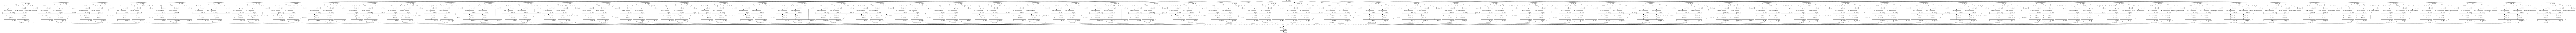

In [6]:
plot_model(model, to_file='model.png', show_shapes=True)

### 4. Load data

In [7]:
# Let's create fake data, with shape: (dataset_size, duration, channel)
x_train = numpy.random.randn(2000, duration, n_channels)
y_train = numpy.random.random_integers(n_classes, size=2000)

x_test = numpy.random.randn(1000, duration, n_channels)
y_test = numpy.random.random_integers(n_classes, size=1000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(1, 14 + 1) instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(1, 14 + 1) instead
  """


In [0]:
# Transform the labels to one-hot encoding for the cross-entropy loss
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

### 5. Training the model

Note: You can use the GPUs provided by Google Colab to make the training faster: go to the “runtime” dropdown menu, select “change runtime type” and select GPU in the hardware accelerator drop-down menu.

In [9]:
# We use Adam to optimize a multi-class classification task
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [10]:
# Start the training
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)
# or, if there is no validation set
# history = model.fit(x_train, y_train, validation_split=0.33, epochs=150, batch_size=10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2000 samples, validate on 1000 samples
Epoch 1/10





2000/2000 [==============================] - 74s 37ms/step - loss: 8.7689 - acc: 0.0760 - val_loss: 5.4479 - val_acc: 0.0840
Epoch 2/10
2000/2000 [==============================] - 14s 7ms/step - loss: 6.4796 - acc: 0.0820 - val_loss: 7.2531 - val_acc: 0.0840
Epoch 3/10
2000/2000 [==============================] - 13s 7ms/step - loss: 7.5916 - acc: 0.0820 - val_loss: 7.3499 - val_acc: 0.0840
Epoch 4/10
2000/2000 [==============================] - 13s 7ms/step - loss: 7.5594 - acc: 0.0820 - val_loss: 7.3499 - val_acc: 0.0840
Epoch 5/10
2000/2000 [==============================] - 13s 7ms/step - loss: 7.5433 - acc: 0.0820 - val_loss: 7.3499 - val_acc: 0.0840
Epoch 6/10
2000/2000 [==============================] - 13s 7ms/step - loss: 7.6722 - acc: 0.0820 - val_loss: 7.3499 - val_acc: 0.0840
Epoch 7/10
2000/2000 [=================

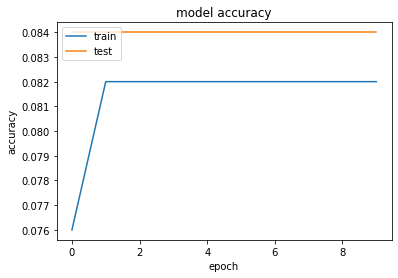

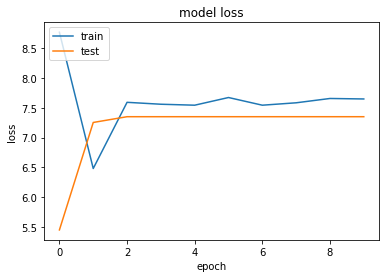

In [11]:
# plot everything
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
_, train_accuracy = model.evaluate(x_train, y_train)
_, test_accuracy = model.evaluate(x_test, y_test)

1000/1000 [==============================] - 1s 1ms/step


In [13]:
print('Accuracy on train set: {:.2f}%'.format(100 * train_accuracy))
print('Accuracy on test set: {:.2f}%'.format(100 * test_accuracy))

Accuracy on train set: 8.20%
Accuracy on test set: 8.40%


### 6. Play with the model

In [0]:
# Fake gesture data
n_demo_gesture = 3
demo_gesture = numpy.random.randn(n_demo_gesture, duration, n_channels)
predicted_prob = model.predict(demo_gesture)
predicted_class = predicted_prob.argmax(axis=-1)

In [15]:
string_format = len(predicted_class) * '{}   '
print('The classes of the gestures are:   ' + string_format.format(*(predicted_class.tolist())) + '.')

The classes of the gestures are:   2   2   2   .


In [0]:
model.save('skeleton_hand_gesture_keras_model.h5')